Reference tutorial: [click here](https://github.com/amazon-braket/amazon-braket-examples/blob/main/examples/hybrid_quantum_algorithms/VQE_Transverse_Ising/VQE_Transverse_Ising_Model.ipynb)


While VQE is a general approach, we'll focus on applying it to the one-dimensional Transverse Ising Model (TIM). The TIM, a type of many-body spin system, is challenging to study on classical computers due to exponential growth in the Hilbert space dimension.

What is TIM?: TIM is a quantum version of the classical Ising model describing spins on a lattice where 
- The nearest neighbor interaction strenght is J set by the alignment/anti-alignment of spin along the z-axis.
- B is the magnetic field along the x-axis creating energy bias for up spin over the down spin and vice versa.

In one dimension, the Hamiltonian for $N$ spin-$1/2$ particles is:

$$H = -J\sum_{i}S_{i}^{z}S_{i+1}^{z} - B\sum_{i}S_{i}^{x}.$$
Transforming spin variables to qubits:
$$H = -\frac{1}{4}\sum_{i}\sigma_{i}^{z}\sigma_{i+1}^{z} - \frac{B}{2}\sum_{i}\sigma_{i}^{x}.$$

Here, $B$ represents the strength of the transverse magnetic field in units of the hopping matrix element $J$.

In [1]:
from braket.tracking import Tracker
t = Tracker().start()

## IMPORTS and SETUP

In [2]:
# general imports
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import time
from datetime import datetime

# AWS imports: Import Braket SDK modules
from braket.circuits import Circuit, observables
from braket.devices import LocalSimulator


# magic word for producing visualizations in notebook
%matplotlib inline

## Properties of the Ising model

__Symmetries and Phases__: The Hamiltonian is invariant under the global rotation of spin along the x-axis by $\pi$
- Formally, this property can be expressed as $R_{x}\mathbf{H}R_{x}^{\dagger}=\mathbf{H}$, since $$R_{x}\sigma_{i}^{z}R_{x}^{\dagger}=-\sigma_{i}^{z}$$ and $$R_{x}\sigma_{i}^{x}R_{x}^{\dagger}=\sigma_{i}^{x}$$, with $R_{x}=\exp(-i \pi/2 \sum_{i}\sigma_{i}^{x})= (-i)^{N}\prod _{i}\sigma_{i}^{x}$ being a global rotation around the $x$-axis by angle $\pi$. 

The 1D model then allows for two phases, depending on whether the ground state $\left|\Psi_{\mathrm{gs}}\right>$ breaks or preserves this global spin-flip symmetry. 

1.  *Ordered Phase*: When the transverse field $B$ is small, the system is in the ordered phase. In this phase the ground state breaks the spin-flip symmetry. Thus, the ground state is in fact two-fold degenerate.
Mathematically, if ${\displaystyle |\psi _{1}\rangle }$  is a ground state of the Hamiltonian, then ${\displaystyle |\psi _{2}\rangle \equiv \prod \sigma^{x}_{j}|\psi _{1}\rangle \neq |\psi _{1}\rangle }$ is a ground state as well. Taken together, these two distinct states span the degenerate ground state space. 
Consider the following example for $B=0$: In this case, the ground state space is spanned by the states ${\displaystyle |\ldots 1,1,1, \ldots \rangle }$ and ${\displaystyle |\ldots 0,0,0, \ldots \rangle }$, that is, with all the qubits aligned along the $z$ axis.
2.  *Disordered Phase*: In contrast, when $B>1$, the system is in the disordered phase. Here, the ground state *does* preserve the spin-flip symmetry, and is nondegenerate (as opposed to the ordered phase discussed above). 

Consider the following example when $B \rightarrow \infty$: Here, the ground state is simply the state aligned with the external magnetic field, ${\displaystyle |\ldots +,+,+, \ldots \rangle}$, with every qubit (spin) pointing in the $x$ direction.

There is a quantum phase transition at $B=1$ separating these two phases. We take this information for granted. Click [here for details](https://en.wikipedia.org/wiki/Transverse-field_Ising_model)




## Prepare the ansatz: 
Now we're ready to prepare the ansatz. Reference paper: [click here](https://arxiv.org/pdf/1804.03719.pdf)
- **Choice of Ansatz for TIM:**
  - In tackling the Transverse Ising Model (TIM), selecting a suitable ansatz is crucial. We opt for one capable of accommodating quantum entanglement.
  - Utilizing $\mathbb{Z}_{2}$ symmetry, we recognize that any state $\left|\Psi(\theta)\right>$ possesses a degenerate counterpart with identical energy upon rotation which leads to the state, $R_{x}\left|\Psi(\theta)\right>$.
  - Thus, our ansatz comprises a linear combination of these degenerate states: $\left|\psi(\theta)\right> = \alpha \left|\Psi(\theta)\right> + \beta R_{x}\left|\Psi(\theta)\right>$.
- **Preparation Procedure on Quantum Computer:**
  - We employ a sequence of parametrized gates to prepare such a state.
  - Initially, from $\left|0000\right>$, a general single qubit rotation is applied to the first qubit, yielding $\alpha \left|000\dots\right> + \beta \left|100\dots\right>$, where the parameters $\alpha$ and $\beta$ are adjustable during the training process.
  - Subsequently, a series of CNOT gates, akin to those used for GHZ state preparation, are applied. For instance, the first CNOT between the first and second qubits prepares the state $\alpha \left|000\dots\right> + \beta \left|110\dots\right>$. This continues until we arrive at the parametrized ansatz $\alpha \left|000\dots\right> + \beta \left|111\dots\right>$. 
  - Finally, to accommodate various polarization directions, parametrized single qubit rotations around the $y$ axis are applied. This yields our VQE trial ansatz state:
  $$\left|\Psi(\theta)\right> = \alpha U_{y}(\theta_{y})\left|000\dots\right> + \beta U_{y}(\theta_{y})\left|111\dots\right>,$$
with $U_{y}(\theta_{y})=\prod \exp(-i \theta_{y}/2 \sigma_{i}^{y})$.

## Run the simulation on local simulator

1. **Experimentation with VQE Simulation:**
   - Begin by conducting VQE simulation experiments.
2. **Adjustment of Qubit Number and Classical Optimizer:**
   - Firstly, explore varying the number of qubits, denoted as $N$.
   - Additionally, experiment with different classical optimizers. By utilizing an off-the-shelf `scipy` minimizer, interchange between optimizers by adjusting the `method` parameter. This can be accomplished similarly to the line `result = minimize(..., method='SLSQP')`. Common options within this library include *Nelder-Mead*, *BFGS*, and *COBYLA*.
3. **Handling Local Optima in Classical Optimization:**
   - Note that the classical optimization step may become trapped in a local optimum rather than reaching the global minimum for our parametrized VQE ansatz wavefunction.
   - To mitigate this issue, execute several optimization loops, each commencing from different random parameter seeds. Specify the number of these loops using the `n_initial` parameter.
   - While this brute-force method doesn't ensure discovering the global optimum, it improves the likelihood of finding an acceptable solution. However, it may necessitate running numerous circuits on the Quantum Processing Unit (QPU).

## Setup the problem

- Within this section, we craft a set of handy utility functions, each with detailed explanations to follow.
- These utilities serve as foundational components for our VQE (Variational Quantum Eigensolver) algorithm:
  1. An essential function named `circuit` is designed to define the parametrized ansatz.
  2. Another crucial function, `objective_function`, is devised to accept a set of variational parameters and compute the associated cost.
  3. Finally, we introduce a function named `train` to execute the entire VQE algorithm with a specified ansatz.


In [3]:
observables.Z(), observables.X()

(Z('qubit_count': 1), X('qubit_count': 1))

In [4]:
#set seed for initial state
np.random.seed(0)

# to save the plot
SAVE_FIG = False

device = LocalSimulator()

In [5]:
## example code for other backends
# from braket.aws import AwsDevice
## choose the on-demand simulator to run your circuit
# device = AwsDevice("arn:aws:braket:::device/quantum-simulator/amazon/sv1")
## choose the Rigetti device to run your circuit
# device = AwsDevice("arn:aws:braket:us-west-1::device/qpu/rigetti/Aspen-M-3")
## choose the Ionq device to run your circuit
# device = AwsDevice("arn:aws:braket:us-east-1::device/qpu/ionq/Harmony")

In [6]:
def get_ising_interactions(n_qubits):
    """
    Sets up the Ising interaction term matrix 
    """
    # Initialize the Ising interaction term matrix
    ising = np.zeros((n_qubits, n_qubits))
    
    # Assign interaction strengths for adjacent qubits
    for ii in range(n_qubits - 1):
        ising[ii][ii + 1] = -1
    ising[0][n_qubits - 1] = -1
    
    # Display the Ising matrix
    print('Ising matrix:\n', ising)
    
    return ising

def circuit(params, n_qubits):
    """
    function to return full VQE circuit ansatz
    input: parameter list with three parameters 
    """

    # instantiate circuit object
    circuit = Circuit()
    
    #apply rotation on the first qubit: play around with this

    # apply series of CNOT gates
    for ii in range(1, n_qubits):
        #

    # add parametrized single-qubit rotations around y
    for qubit in range(n_qubits):
        #
    return circuit

def objective_function(params, J, b_field, n_qubits, n_shots):
    """
    Computes the cost associated with the given parameters.
    """

    # Obtain the VQE circuit ansatz
    vqe_circuit = circuit(params, n_qubits)
    
    # Measure the Z and X observables
    circuit_zz = Circuit(vqe_circuit).sample(observables.Z())
    task_zz = device.run(circuit_zz, shots=n_shots)
    circuit_b = #
    task_b = #
    
    # Retrieve measurement results
    result_zz = task_zz.result()
    result_b = #
    
    # Compute energy expectation values
    # print("expectations_zz", expectations_zz)
    # print("np.einsum('ik,ij', expectations_zz, J), shape", np.einsum('ik,ij', expectations_zz, J), np.einsum('ik,ij', expectations_zz, J).shape)
    # print("np.einsum('ik,ij,jk', expectations_zz, J, expectations_zz)", np.einsum('ik,ij,jk', expectations_zz, J, expectations_zz))

    expectations_zz = np.array(result_zz.values[0])
    energy_expect_zz = 0.25 * np.einsum("ik,ij,jk", expectations_zz, J, expectations_zz) / n_shots
    energy_expect_b = -1 * b_field / 2 * np.array(result_b.values[0]).sum() / n_shots
    energy_expect = #

    return energy_expect

def train(J, b_field, options, n_qubits, n_shots, n_initial=10):
    """
    Runs the VQE algorithm with several random seeds for initialization.
    """
    print('Starting the training.')
    
    # Initialize lists to store optimization results
    cost_energy = []
    angles = []
    
    # Iterate through different random seeds
    for ii in range(n_initial):
        
        # Generate random initial parameters
        params0 = np.random.uniform(0, 2 * np.pi, 3).tolist()
        
        # Perform optimization
        result = minimize(
            objective_function,
            params0,
            args=(J, b_field, n_qubits, n_shots),
            options=options, method='COBYLA',
        )
        
        # Store optimization results
        result_energy = result.fun
        cost_energy.append(result_energy)
        result_angle = result.x
        angles.append(result_angle)
        
    
    # Determine energy minimum (over different initial configurations)

    energy_min = np.min(cost_energy)
    
    return energy_min


IndentationError: expected an indented block after 'for' statement on line 30 (2807321905.py, line 34)

In [ ]:
# visualize VQE circuit example
N = 4
params = [0.1, 0.2]

vqe_circuit = circuit(params, N)

print('1. Printing VQE test circuit:')
print(vqe_circuit)

# Hb term: construct the circuit for measuring in the X-basis
print('')
print('2. Apply Hadamard to measure in x-basis:')
print(Circuit(vqe_circuit).h(range(0, N)))

1. Printing VQE test circuit:
T  : |   0    |1|    2     |    3     |   4    |
                                                
q0 : -Rx(0.10)-C-C----------C----------Ry(0.20)-
               | |          |                   
q1 : ----------X-|-Ry(0.20)-|-------------------
                 |          |                   
q2 : ------------X----------|-Ry(0.20)----------
                            |                   
q3 : -----------------------X----------Ry(0.20)-

T  : |   0    |1|    2     |    3     |   4    |

2. Apply Hadamard to measure in x-basis:
T  : |   0    |1|    2     |    3     |   4    |5|
                                                  
q0 : -Rx(0.10)-C-C----------C----------Ry(0.20)-H-
               | |          |                     
q1 : ----------X-|-Ry(0.20)-|-H-------------------
                 |          |                     
q2 : ------------X----------|-Ry(0.20)-H----------
                            |                     
q3 : -----------------------X

In [ ]:
# visualize VQE circuit example
N = 4
params = [0.1, 0.2]

vqe_circuit = circuit(params, N)

print('1. Printing VQE test circuit:')
print(vqe_circuit)

# Hb term: construct the circuit for measuring in the X-basis
print('')
print('2. Apply Hadamard to measure in x-basis:')
print(Circuit(vqe_circuit).h(range(0, N)))

1. Printing VQE test circuit:
T  : |   0    |1|    2     |    3     |   4    |
                                                
q0 : -Rx(0.10)-C-C----------C----------Ry(0.20)-
               | |          |                   
q1 : ----------X-|-Ry(0.20)-|-------------------
                 |          |                   
q2 : ------------X----------|-Ry(0.20)----------
                            |                   
q3 : -----------------------X----------Ry(0.20)-

T  : |   0    |1|    2     |    3     |   4    |

2. Apply Hadamard to measure in x-basis:
T  : |   0    |1|    2     |    3     |   4    |5|
                                                  
q0 : -Rx(0.10)-C-C----------C----------Ry(0.20)-H-
               | |          |                     
q1 : ----------X-|-Ry(0.20)-|-H-------------------
                 |          |                     
q2 : ------------X----------|-Ry(0.20)-H----------
                            |                     
q3 : -----------------------X

In [ ]:
# set up the problem
SHOTS = 1_000
N = 4 # number of qubits
n_initial = 2 # number of random seeds to explore optimization landscape
verbose = False # control amount of print output in scipy

# set up Ising matrix with nearest neighbour interactions and PBC
J = get_ising_interactions(N)

# set options for classical optimization
options = {"maxiter": 20}
if verbose:
    options["disp"] = True

# kick off training
start = time.time()

# parameter scan
xvalues = np.arange(0.01, 2.2, 0.2)
results = []
results_site = []

for bb in xvalues:
    b_field = bb
    print('Strength of magnetic field:', b_field)
    energy_min = train(
        J,
        b_field,
        options=options,
        n_qubits=N,
        n_shots=SHOTS,
        n_initial=n_initial,
    )
    results.append(energy_min)
    results_site.append(energy_min/N)
    
    # reset counters
    CYCLE = 0

end = time.time()
# print execution time
print('Code execution time [sec]:', end - start)

# print optimized results
print('Optimal energies:', results)
print('Optimal energies (per site):', results_site)

Ising matrix:
 [[ 0. -1.  0. -1.]
 [ 0.  0. -1.  0.]
 [ 0.  0.  0. -1.]
 [ 0.  0.  0.  0.]]
Strength of magnetic field: 0.01
Starting the training.
Strength of magnetic field: 0.21000000000000002
Starting the training.
Strength of magnetic field: 0.41000000000000003
Starting the training.
Strength of magnetic field: 0.6100000000000001
Starting the training.
Strength of magnetic field: 0.81
Starting the training.
Strength of magnetic field: 1.01
Starting the training.
Strength of magnetic field: 1.2100000000000002
Starting the training.
Strength of magnetic field: 1.4100000000000001
Starting the training.
Strength of magnetic field: 1.61
Starting the training.
Strength of magnetic field: 1.81
Starting the training.
Strength of magnetic field: 2.01
Starting the training.
Code execution time [sec]: 6.187764883041382
Optimal energies: [-0.99984, -1.04858, -1.20725, -1.39616, -1.66257, -2.02613, -2.43874, -2.8045000000000004, -3.246, -3.64152, -4.019949999999999]
Optimal energies (per site)

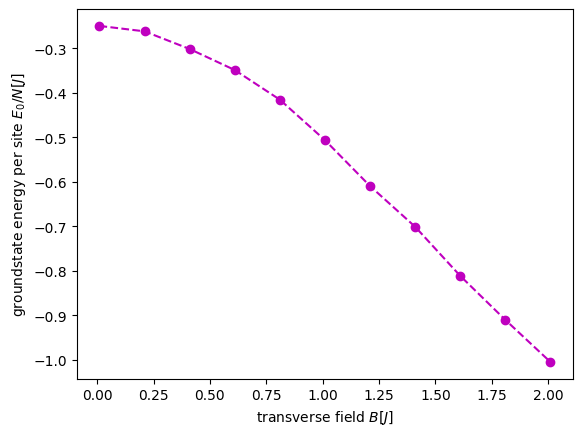

In [ ]:
# plot the VQE results for the energy per site
plt.plot(xvalues, results_site, 'm--o')
plt.xlabel('transverse field $B [J]$')
plt.ylabel('groundstate energy per site $E_{0}/N [J]$')
plt.show()

## Compare with exact result 
Click [here for reference paper](https://www.math.ucdavis.edu/~bxn/pfeuty1970.pdf). 

In [ ]:
# helper function to numerically solve for gs energy of TIM
def num_integrate_gs(B):
    """
    numerically integrate exact band to get gs energy of TIM
    this should give -E_0/(N*J) by Pfeufy
    Here set J=1 (units of energy)
    """
    # lamba_ratio (setting J=1): compare thesis
    ll = 1/(2*B)
    
    # set energy
    gs_energy = 0
    
    # numerical integration
    step_size = 0.0001
    k_values = np.arange(0, np.pi, step_size)
    integration_values = [step_size*np.sqrt(1 + ll**2 + 2 * ll * np.cos(kk)) for kk in k_values]
    integral = np.sum(integration_values)
    gs_energy = 1*integral/(4*np.pi*ll)
    
    return gs_energy

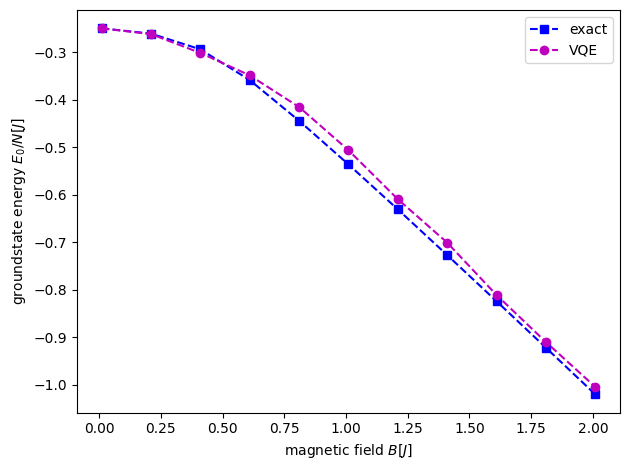

In [ ]:
# plot exact gs energy of TIM vs VQE results
x = np.arange(0.01, 2.2, 0.2)
y = [-1*num_integrate_gs(xx) for xx in x]
# plot exact results
plt.plot(x, y, 'b--s', label='exact')
# plot vqe results
plt.plot(xvalues, results_site, 'm--o', label='VQE')
plt.xlabel('magnetic field $B [J]$')
plt.ylabel('groundstate energy $E_{0}/N [J]$')
plt.tight_layout();
plt.legend()
# save figure
if SAVE_FIG:
    time_now = datetime.strftime(datetime.now(), '%Y%m%d%H%M%S')
    filename = 'vqe_tim_gs-energy_'+time_now+'.png'
    plt.savefig(filename, dpi=700);